# 핵심문장을 사용하여 키워드를 추출하는 모델
- 텍스트나 곡을 통해 주요 키워드 추출 가능
- 사용한 데이터: 단편소설이나 사연(텍스트), 라흐마니노프 피아노곡, 노래가사

## 1. Import Packages

In [1]:
!nvidia-smi

Fri Apr 23 05:07:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install konlpy

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os
from collections import Counter

In [79]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.sequence import skipgrams

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import pickle

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import nltk

In [9]:
from konlpy.tag import Okt

In [10]:
from google.colab import drive

## 2. Drive Mount

In [12]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
%cd /content/drive/MyDrive/Colab Notebooks/Project/Lyrics/1_TextRank

/content/drive/MyDrive/Colab Notebooks/Project/Lyrics/1_TextRank


In [14]:
!ls -l

total 0


## 3. 노래가사 데이터 로드

In [15]:
df = pd.read_csv('../Data/2_LSTM_Ballard_Data.csv')

In [16]:
df.head()

,Unnamed: 0,title,singer,lyrics
0,0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신\n거룩하고 사랑스러운 자니 \n긍율과 자비와 \n겸손과 온유...
1,1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 \n아직까지도 마음이 저려 오는 건 \n\n그건...
2,2,Going Home,김윤아,집으로 돌아가는 길에\n지는 햇살에 마음을 맡기고\n나는 너의 일을 떠올리며\n수많...
3,3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 \n계절이 다 가도록 나는 애만 태우네 \n...
4,4,길,김윤아,아무도 가르쳐 주지 않아\n이 길이 옳은지 다른 길로 가야 할지\n난 저길 저 끝에...


## 4. 데이터 전처리

### 1) 결측치 제거

In [17]:
df.dropna(axis=0, inplace = True)

### 2) 정규화(한글을 제외하고 모두 제거)

In [18]:
df['lyrics'] = df['lyrics'].str.replace('[^가-힣]' , ' ')

In [19]:
df.head()

,Unnamed: 0,title,singer,lyrics
0,0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신 거룩하고 사랑스러운 자니 긍율과 자비와 겸손과 온유와 오...
1,1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 아직까지도 마음이 저려 오는 건 그건 아마...
2,2,Going Home,김윤아,집으로 돌아가는 길에 지는 햇살에 마음을 맡기고 나는 너의 일을 떠올리며 수많은 생...
3,3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 계절이 다 가도록 나는 애만 태우네 꽃잎...
4,4,길,김윤아,아무도 가르쳐 주지 않아 이 길이 옳은지 다른 길로 가야 할지 난 저길 저 끝에 다...


In [20]:
lyrics = list(df['lyrics'])

### 3) 불용어 제거
- stop_words.txt

In [34]:
stopwords = []
with open('../Data/1_TextRank_Data/1_TextRank_Stopwords.txt' , 'r') as f:
  for line in f:
    a = line.split('\n')
    stopwords.append(a[0])

In [ ]:
stopwords

### 4) 단어 토큰화

In [23]:
%%time

okt = Okt()
tokenized_data = []

for lyric in lyrics :
  temp_X = okt.morphs(lyric, stem = False) # 토큰화(형태소 별로 나눠짐)
  # temp_X = okt.nouns(lyric)  
  temp_X = [word for word in temp_X if len(word) > 1 and not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

CPU times: user 43.2 s, sys: 511 ms, total: 43.7 s
Wall time: 30.6 s


In [24]:
len(tokenized_data)

1243

### 5) 빈도수가 높은 단어 순서로 정렬

In [ ]:
words = sum(tokenized_data, [])
vocab = Counter(words)

In [28]:
print(vocab)

Counter({'사랑': 2708, '그대': 2078, '사람': 886, '다시': 838, '나를': 758, '마음': 716, '눈물': 603, '없는': 591, '이제': 541, '너무': 528, '내게': 518, '기억': 517, '세상': 510, '가슴': 472, '오늘': 418, '생각': 417, '이렇게': 404, '하고': 395, '아무': 384, '모습': 377, '모든': 362, '지금': 352, '추억': 349, '하나': 349, '이별': 319, '있어': 318, '하루': 317, '있는': 311, '하는': 304, '하지': 301, '같은': 297, '혼자': 294, '해도': 289, '거야': 287, '없어': 282, '없이': 279, '보고': 277, '노래': 271, '했던': 271, '바람': 258, '우린': 255, '처음': 244, '그냥': 227, '버린': 220, '그런': 220, '얼굴': 209, '아직': 208, '말아요': 205, '많은': 201, '정말': 196, '서로': 194, '많이': 193, '얘기': 193, '싶어': 190, '순간': 190, '하늘': 189, '보다': 188, '그렇게': 187, '마지막': 185, '한번': 182, '나도': 177, '위해': 174, '가끔': 169, '제발': 165, '만큼': 165, '언제나': 163, '거리': 163, '매일': 162, '이런': 159, '우우': 154, '이유': 154, '라도': 152, '않아': 152, '이란': 152, '그녀': 152, '같아': 150, '좋아': 148, '후회': 146, '좋은': 145, '지난': 143, '싶은': 142, '멀리': 140, '바보': 139, '아픈': 138, '웃음': 138, '아직도': 138, '수가': 136, '가는': 134, '이야': 130, '소리'

In [29]:
vocab = vocab.most_common()
print(vocab)

[('사랑', 2708), ('그대', 2078), ('사람', 886), ('다시', 838), ('나를', 758), ('마음', 716), ('눈물', 603), ('없는', 591), ('이제', 541), ('너무', 528), ('내게', 518), ('기억', 517), ('세상', 510), ('가슴', 472), ('오늘', 418), ('생각', 417), ('이렇게', 404), ('하고', 395), ('아무', 384), ('모습', 377), ('모든', 362), ('지금', 352), ('추억', 349), ('하나', 349), ('이별', 319), ('있어', 318), ('하루', 317), ('있는', 311), ('하는', 304), ('하지', 301), ('같은', 297), ('혼자', 294), ('해도', 289), ('거야', 287), ('없어', 282), ('없이', 279), ('보고', 277), ('노래', 271), ('했던', 271), ('바람', 258), ('우린', 255), ('처음', 244), ('그냥', 227), ('버린', 220), ('그런', 220), ('얼굴', 209), ('아직', 208), ('말아요', 205), ('많은', 201), ('정말', 196), ('서로', 194), ('많이', 193), ('얘기', 193), ('싶어', 190), ('순간', 190), ('하늘', 189), ('보다', 188), ('그렇게', 187), ('마지막', 185), ('한번', 182), ('나도', 177), ('위해', 174), ('가끔', 169), ('제발', 165), ('만큼', 165), ('언제나', 163), ('거리', 163), ('매일', 162), ('이런', 159), ('우우', 154), ('이유', 154), ('라도', 152), ('않아', 152), ('이란', 152), ('그녀', 152), ('같아', 150), ('좋아

### 6) 높은 빈도수를 가진 단어일수록 낮은 정수 인덱스 부여
- word_to_index, index_to_word 딕셔너리 생성

In [30]:
word_to_index = {}

i = 0
for (word, frequency) in vocab:
  i += 1
  word_to_index[word] = i

index_to_word = {k:v for v, k in word_to_index.items()}

In [31]:
print("word_to_index: " , word_to_index)
print("index_to_word: " , index_to_word)

word_to_index:  {'사랑': 1, '그대': 2, '사람': 3, '다시': 4, '나를': 5, '마음': 6, '눈물': 7, '없는': 8, '이제': 9, '너무': 10, '내게': 11, '기억': 12, '세상': 13, '가슴': 14, '오늘': 15, '생각': 16, '이렇게': 17, '하고': 18, '아무': 19, '모습': 20, '모든': 21, '지금': 22, '추억': 23, '하나': 24, '이별': 25, '있어': 26, '하루': 27, '있는': 28, '하는': 29, '하지': 30, '같은': 31, '혼자': 32, '해도': 33, '거야': 34, '없어': 35, '없이': 36, '보고': 37, '노래': 38, '했던': 39, '바람': 40, '우린': 41, '처음': 42, '그냥': 43, '버린': 44, '그런': 45, '얼굴': 46, '아직': 47, '말아요': 48, '많은': 49, '정말': 50, '서로': 51, '많이': 52, '얘기': 53, '싶어': 54, '순간': 55, '하늘': 56, '보다': 57, '그렇게': 58, '마지막': 59, '한번': 60, '나도': 61, '위해': 62, '가끔': 63, '제발': 64, '만큼': 65, '언제나': 66, '거리': 67, '매일': 68, '이런': 69, '우우': 70, '이유': 71, '라도': 72, '않아': 73, '이란': 74, '그녀': 75, '같아': 76, '좋아': 77, '후회': 78, '좋은': 79, '지난': 80, '싶은': 81, '멀리': 82, '바보': 83, '아픈': 84, '웃음': 85, '아직도': 86, '수가': 87, '가는': 88, '이야': 89, '소리': 90, '어제': 91, '친구': 92, '아침': 93, '그대로': 94, '내겐': 95, '목소리': 96, '영원히': 97, '그게': 98, '자꾸

## 5. 라흐마니노프의 곡 로드
- note_embedding: 사전학습된 임베딩 값
- notes: 사용된 화음
- durations: 박자

In [36]:
# 하이퍼퍼라미터
EMBED_SIZE = 200
DATA_PATH = '../Data/1_TextRank_Data/'

# 데이터 이름
data_name = 'Rachmaninov'
pickle_name = 'Rachmaninov_pickle'

In [37]:
with open(DATA_PATH + '1_TextRank_note_embeddings.pickle' , 'rb') as f:
  note_embedding = pickle.load(f)

In [39]:
with open(DATA_PATH + '{}_notes'.format(pickle_name), 'rb') as f:
  notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
with open(DATA_PATH + '{}_durations'.format(pickle_name), 'rb') as f:
  durations = pickle.load(f)

In [40]:
len(note_embedding)

2165

### 1) 곡의 note를 20 단위의 멜로디로 리스트화

In [53]:
SEQ_LEN = 20

melody = []
last_idx = -1
for i, note in enumerate(notes):

  if i < last_idx : continue
  if note == 'START':
    continue

  else:
    last_idx = i + SEQ_LEN
    melody.append(notes[i:i + SEQ_LEN])

In [54]:
melody[1]

['G#5.G#4.C#5.B4.C#4.B3',
 'F#5.C#5.F#4.A4.C#4.A3',
 'C4.C2.C3',
 'E4.A4.E5.F#4.A3.F#3',
 'B3.B1.B2',
 'E-5.E-4.A4.F#4.A3.F#3',
 'E3.E1.E2',
 'E5.E4.B4.G#4.B3.G#3',
 'B5.E5.B4.E-5.E4.E-4',
 'E5.A5.A4.C#5.E4.C#4',
 'E4.E2.E3',
 'G#4.G#5.C#5.B-4.C#4.B-3',
 'E-4.E-2.E-3',
 'C#5.G4.G5.B-4.C#4.B-3',
 'G#3',
 'G#1.G#2',
 'G#4.G#5.E-5.B4.E-4.B3',
 'E5.A5.A4.C#5.E4.C#4',
 'F#5.F#4.C#5.A4.C#4.A3',
 'G#5.G#4.E-5.B4.E-4.B3']

In [55]:
len(melody)

466

### 2) 사용빈도가 높은 note 순으로 인덱스 정렬

In [56]:
note_list = sum(melody, [])
note_count = Counter(note_list)
print(note_count)

Counter({'D3': 179, 'B-3': 172, 'C#3': 164, 'B-2': 155, 'F3': 155, 'G3': 151, 'D4': 145, 'G4': 132, 'C#4': 130, 'C#5': 127, 'A2': 123, 'G#3': 121, 'E-4': 121, 'F4': 114, 'A3': 113, 'E-5': 109, 'F5': 107, 'G#2': 103, 'C4': 102, 'B-4': 101, 'F2': 93, 'G#4': 92, 'F#4': 91, 'G2': 91, 'C#2': 90, 'D5': 90, 'B-5': 90, 'E3': 89, 'F#3': 86, 'A4': 84, 'C5': 81, 'G5': 74, 'G#5': 73, 'F#5': 71, 'E-3': 71, 'E4': 69, 'B3': 67, 'B4': 62, 'A1': 61, 'C3': 53, 'C#1': 53, 'E5': 48, 'A5': 46, 'C6': 44, 'E-6': 43, 'D2': 43, 'G6': 42, 'E2': 40, 'B2': 37, 'C#6': 36, 'B5': 35, 'D6': 35, 'B-1': 35, 'F6': 33, 'E-2': 32, 'F#2': 30, 'START': 28, 'D4.B-3': 26, 'B-5.B-4': 23, 'G#1': 23, 'B-3.D4.D3.G3': 23, 'G#6': 23, 'B-6': 21, 'B-2.B-1': 19, 'D4.D3': 19, 'B-4.D5': 18, 'C2': 18, 'D4.F4': 17, 'E-4.E-3': 17, 'F#6': 17, 'C#1.C#2': 16, 'B-4.B-5': 16, 'G3.G1.G2': 15, 'G4.G3': 15, 'C5.E-5': 14, 'A2.A1': 14, 'F1.F2': 14, 'B-4.B-3': 14, 'C#6.C#5': 14, 'B-3.B-2': 14, 'E-3.G3': 14, 'C#3.C#1.C#2': 13, 'E4.C#4': 13, 'G5.G4': 1

In [57]:
note_count = note_count.most_common()

In [58]:
print(note_count[:10])

[('D3', 179), ('B-3', 172), ('C#3', 164), ('B-2', 155), ('F3', 155), ('G3', 151), ('D4', 145), ('G4', 132), ('C#4', 130), ('C#5', 127)]


In [59]:
note_to_index = {}

i = 0
for (note, frequency) in note_count:
  i += 1
  note_to_index[note] = i

In [60]:
index_to_note = {k:v for v, k in note_to_index.items()}

In [61]:
print("index_to_note: " , index_to_note)
print("note_to_index: " , note_to_index)

index_to_note:  {1: 'D3', 2: 'B-3', 3: 'C#3', 4: 'B-2', 5: 'F3', 6: 'G3', 7: 'D4', 8: 'G4', 9: 'C#4', 10: 'C#5', 11: 'A2', 12: 'G#3', 13: 'E-4', 14: 'F4', 15: 'A3', 16: 'E-5', 17: 'F5', 18: 'G#2', 19: 'C4', 20: 'B-4', 21: 'F2', 22: 'G#4', 23: 'F#4', 24: 'G2', 25: 'C#2', 26: 'D5', 27: 'B-5', 28: 'E3', 29: 'F#3', 30: 'A4', 31: 'C5', 32: 'G5', 33: 'G#5', 34: 'F#5', 35: 'E-3', 36: 'E4', 37: 'B3', 38: 'B4', 39: 'A1', 40: 'C3', 41: 'C#1', 42: 'E5', 43: 'A5', 44: 'C6', 45: 'E-6', 46: 'D2', 47: 'G6', 48: 'E2', 49: 'B2', 50: 'C#6', 51: 'B5', 52: 'D6', 53: 'B-1', 54: 'F6', 55: 'E-2', 56: 'F#2', 57: 'START', 58: 'D4.B-3', 59: 'B-5.B-4', 60: 'G#1', 61: 'B-3.D4.D3.G3', 62: 'G#6', 63: 'B-6', 64: 'B-2.B-1', 65: 'D4.D3', 66: 'B-4.D5', 67: 'C2', 68: 'D4.F4', 69: 'E-4.E-3', 70: 'F#6', 71: 'C#1.C#2', 72: 'B-4.B-5', 73: 'G3.G1.G2', 74: 'G4.G3', 75: 'C5.E-5', 76: 'A2.A1', 77: 'F1.F2', 78: 'B-4.B-3', 79: 'C#6.C#5', 80: 'B-3.B-2', 81: 'E-3.G3', 82: 'C#3.C#1.C#2', 83: 'E4.C#4', 84: 'G5.G4', 85: 'F2.C3', 86: '

## 6. 텍스트 로드

In [76]:
sentences = '''이곳은 별로 크지 않고, 깔끔하지도 않은 극장이다. 어딜 가더라도 눅눅한 냄새가 느껴지는 극장이다. 그렇지만, 나는 다른 극장보다 천 원이 싸고, 사람들이 얼마 없는데다가 극장 앞 노점에서 파는 문어 다리가 맛있다는 이유로 이 극장에 자주 온다. 극장 안은 고양이가 쥐를 모두 잡아먹은 후의 쥐구멍 속처럼 조용하지만, 노점들이 가득한 극장 앞 거리는 지나다니는 보행자들로 가득 차 있다. 극장 바깥에서 담배 한 대 피우기가 민망할 정도로 사람이 많이 지나다닌다. 게다가 까만 옷, 하얀 옷을 입은 사람들은 다리가 보이지 않는 속도로 걸어간다. 
  
    사람들을 바라보면서 혼자 중얼거린다. “왜 저 인간들은 이 극장 놔두고, CGV니 메가박스니 하는 정신 없는 극장에 가는 걸까? 그리고 뭐 저리들 바쁜 걸까?” 모두가 “상대적인 거니까.”라는 절대적인 답을 하리란 걸 아는 나는 스스로 답하는 것 따위에는 관심이 없다. 이 질문은 그저 ‘나는 내 세상이 있어’라는 자만심 가득한 말을 에둘러 표현한 것에 불과하다고 반성을 한다. 그리고 말한다. “머리가 아프다, 이런 생각을 하니까.” 나는 사람 구경이나 더 할 요량으로, 복도에서 건물 바깥으로 나간다. 
  
    입구 계단에 앉아서 인상을 잔뜩 찌푸린 한 남자가 보인다. 그 옆에는 담배 필터를 씹어대는 한 여자가 있다. 둘이 감정 없는 목소리로 나누는 인사 소리가 들려온다. “안녕하세요.” 그리고 이어지는 “예에.” 나는 아주 작은 목소리로 “저따위 목소리로 인사할 바에야, 그냥 모르는 체 하겠다. 차가운 인간들.”이라고 그들의 대화 뒤에 내 말을 친절하게 덧붙인다. 사람들의 대화라는 일종의 상차림에다가 내 말을 하나 올려 놓고 싶을 뿐이다. 그냥 내가 외로우니까.
  
    남자가 극장 안으로 다시 들어간다. 나도 따라 들어간다. “저 사람, 괜히 마음에 든다.”고 중얼거려본다. 까칠한 말동무가 필요한 날이다. 이 극장에 오는 몇 안 되는 사람들 중에 까칠한 사람을 발견한다는 건 드문 일이다. 내가 꼬리에 꼬리를 물고 끄집어 내는 머리 속의 생각들을 찬찬히 살펴 보면, 내게는 까칠한 사람들이 어울린다. 까칠하고 말 잘라먹기 좋아하는 외계인들은 빌어먹지도 못 할 잰 체하는 마초보다야 1000 배는 낫고, 긴장해서 말을 더듬는 숙맥보다는 43배 정도 낫다. 상영관으로 따라 들어간다. 그리고 남자의 옆의 옆 자리에 앉는다. 문어 다리를 씹다가, 남자에게 문어 다리 몇 개를 건네며 수다쟁이처럼 말한다. “웃으실 때, 담배 냄새 풍겨요. 문어 다리 하나 드세요. 아, 장난이에요. 아줌마가 문어다리를 너무 많이 줬네요. 조금 드세요. 더 먹고 싶으면 말씀하시고요.” 남자는 문어 다리를 받아 들고 “고맙네요. 담배 냄새나, 문어 다리 냄새나 뭐.”라고 말한다. 영화가 시작할 즈음, 남자는 조용히 문어를 씹기 시작한다. 
  
    영화를 보는 내내, 쥐 구멍 속에서 바깥으로 나가기는 싫지만, 구멍 안에서 다른 쥐랑 같이 있자니 불편해 죽을 것 같은 쥐새끼 같은 마음 상태다. 남자는 문어 다리를 씹는 것 말고는 눈길 한 번 주지 않고, 영화는 지루한데다가, 꼬리에 꼬리를 물고 떠오르는 온갖 잡생각들 때문에 나한테 짜증이 난다. 결국 “문어 다리도 혼자서나 씹자. 사람 구경은 해서 뭐하니, 아까 담배나 피우고 들어올 걸 그랬다. 듣지도 않는 말이나 떠들고, 나는 글러먹은 사람이다.”라고 투덜대며 영화가 미처 끝나지도 않았지만, 상영관을 빠져 나온다. 
  
    "차라리 CGV에나 가서 쁘띠 부르주아지 놀이나 할 걸 그랬나? 지저분한 극장에 들어갔더니 젠장 할 내 머리만 복잡해진다.” 노점이 가득한 인도 끝자락에 서서 중얼거린다. “아, 지랄 맞다. 나 정말 글러먹은 인간이야.” 아까 문어 다리를 산 노점 아줌마가 내게 말한다. “정신 차려. 호랑이한테 잡혀갈라. 어흥.” 나는 허하게 웃는다. '''

### 1) 텍스트 데이터 전처리

In [77]:
okt = Okt()
def preprocess_sentences(sentences):
  sentences = sent_tokenize(sentences)
  return [preprocess_sentence(sentence) for sentence in sentences]

def preprocess_sentence(sentence):
  sentence = re.sub(r'[^가-힣A-Za-z0-9]', '', sentence)
  sentence = okt.morphs(sentence, stem = False)
  return [word for word in sentence]

def tokenization(sentences):
  return [word_tokenize(sentence) for sentence in sentences]  

In [81]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [82]:
sentences = preprocess_sentences(sentences)

print(sentences)

[['이', '곳', '은', '별', '로크', '지', '않고', '깔끔하지도', '않은', '극장', '이다'], ['어딜', '가더라도', '눅눅한', '냄새', '가', '느껴지는', '극장', '이다'], ['그렇지', '만나는', '다른', '극장', '보다', '천원', '이', '싸고', '사람', '들', '이', '얼마', '없는데다', '가극장', '앞', '노점', '에서', '파는', '문어', '다리', '가', '맛있다는', '이', '유로', '이', '극장', '에', '자', '주온', '다'], ['극', '장안', '은', '고양이', '가', '쥐', '를', '모두', '잡아먹은', '후의', '쥐구멍', '속', '처럼', '조용하지만', '노점', '들', '이', '가득한', '극장', '앞', '거리', '는', '지나다니는', '보행자', '들', '로', '가득', '차있다'], ['극장', '바깥', '에서', '담배', '한', '대피', '우기', '가', '민망할', '정도', '로', '사람', '이', '많이', '지나', '다닌다'], ['게다가', '까만', '옷', '하얀', '옷', '을', '입은', '사람', '들', '은', '다리', '가보', '이지', '않는', '속도', '로', '걸어간다'], ['사람', '들', '을', '바라보면서', '혼자', '중얼거린다'], ['왜', '저', '인간', '들', '은', '이', '극장', '놔두고', 'CGV', '니', '메가박스', '니', '하는', '정신', '없는', '극장', '에가', '는걸', '까'], ['그리고', '뭐', '저리', '들', '바쁜', '걸까', '모두', '가상', '대적', '인거', '니까', '라는', '절대', '적', '인', '답', '을', '하리', '란', '걸아는나는', '스스로', '답', '하는것', '따위', '에는', '관심', '이', '없다'], ['이', '질문',

## TextRank로 주요문장 추출
- 문장(혹은 멜로디)의 벡터 평균을 구함
- 벡터 평균의 코사인 유사도를 구함
- 유사도 점수를 계산하여 상위 문장 추출

## 6. 필요한 함수 정의

### 1) 문장(노래구절)의 벡터 평균 계산

In [62]:
embedding_dim = 200
zero_vector = np.zeros(embedding_dim)

def calculate_sentence_vector(sentence):
  sum = np.zeros(embedding_dim)
  for note in sentence :
    if len(sentence) != 0 and note in note_embedding.keys():
      sum += note_embedding[note]
    else : 
      sum += zero_vector

  return sum /len(sentence)

In [63]:
def sentences_to_vectors(sentences) :
  return [calculate_sentence_vector(sentence) for sentence in sentences]

### 2) 유사도 행렬

In [64]:
def similarity_matrix(sentence_embedding) :
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])

  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                        sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat 

### 3) 유사도를 그림으로 표현

In [65]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

### 4) 유사도 점수 계산

In [66]:
def calculate_score(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank_numpy(nx_graph)
  return scores

In [ ]:
# 리스트 flatten 함수 정의
def flat_list(array): 
  a=[]
  for i in array:
    if type(i) == type(list()):
      a+=(flat_list(i))
    else:
      a.append(i)
  return a

### 5) 점수가 높은 문장 반환

In [67]:
def ranked_sentences(sentences, scores, n=3):
  top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
  top_n_sentences = [sentence for score,sentence in top_scores[:n]]
  # top_n_sentences = flat_list(top_n_sentences)
  return top_n_sentences

## 7. 실행

### 1) 텍스트(소설)

In [83]:
sentence_embedding = sentences_to_vectors(sentences)

In [85]:
text_sim_matrix = similarity_matrix(sentence_embedding)

In [91]:
scores = calculate_score(text_sim_matrix)
ranked_text = ranked_sentences(sentences, scores, n = 5)

In [93]:
text_list = []

for tokens in ranked_text:
  real_sentence = ""
  for token in tokens:
    real_sentence += token + " "
  text_list.append(real_sentence)

In [94]:
text_list

['이 곳 은 별 로크 지 않고 깔끔하지도 않은 극장 이다 ',
 '어흥 나 는 허하게 웃는다 ',
 '호랑이 한테 잡혀갈라 ',
 '차라리 CGV 에나 가 서 쁘띠부르주아 지 놀이 나 할 걸 그랬나 ',
 '차가운 인간 들 이라고 그 들 의 대화 뒤 에 내 말 을 친절하게 덧붙인다 ']

### 2) 라흐마니노프 곡

- 구절의 벡터 평균 계산

In [68]:
melody_embedding = sentences_to_vectors(melody)

- 코사인 유사도 계산

In [ ]:
%%time

sim_matrix = similarity_matrix(melody_embedding)

CPU times: user 44 s, sys: 695 ms, total: 44.7 s
Wall time: 44.2 s


In [84]:
DATA_PATH = '../Data/1_TextRank_Data/1_TextRank_sim_matrix.pickle'
with open(DATA_PATH, 'rb') as f:
  melody_sim_matrix = pickle.load(f)

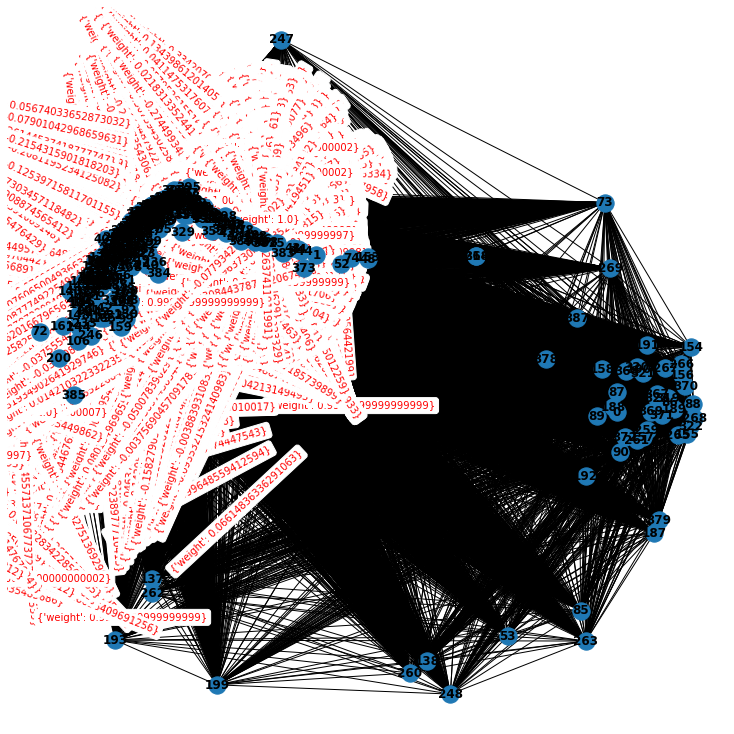

In [ ]:
draw_graphs(sim_matrix)

- 유사도 점수 계산

In [72]:
scores = calculate_score(sim_matrix)
ranked_melody = ranked_sentences(melody, scores, n = 10)

In [ ]:
ranked_melody

- 상위 10개 멜로디의 화음을 인덱스 값으로 변환

In [95]:
melody_int_list = []
for notes in ranked_melody:
  melody_int_list.append([note_to_index[note] for note in notes])
print(melody_int_list)

[[7, 14, 274, 275, 96, 21, 4, 1, 28, 135, 95, 58, 6, 5, 543, 169, 285, 5, 68, 53], [107, 14, 133, 5, 4, 1, 5, 2, 7, 14, 274, 275, 96, 21, 4, 1, 28, 135, 95, 58], [18, 5, 28, 1868, 35, 29, 6, 9, 13, 8, 784, 10, 16, 172, 1869, 12, 10, 31, 38, 15], [763, 452, 58, 1844, 367, 2, 37, 15, 2, 13, 9, 7, 13, 23, 8, 20, 22, 38, 26, 16], [15, 2, 9, 1850, 37, 12, 2, 37, 3, 29, 2, 13, 14, 23, 22, 20, 38, 10, 16, 17], [128, 129, 108, 53, 66, 21, 4, 87, 276, 277, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132], [28, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132, 107, 14, 133, 5, 4, 1, 5, 2], [542, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132, 107, 14, 133, 5, 4, 1, 5, 2], [4, 1, 28, 72, 5, 126, 127, 87, 128, 129, 108, 53, 66, 21, 4, 87, 276, 277, 66, 58], [128, 129, 108, 53, 66, 21, 4, 1, 542, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132]]


- 화음의 인덱스를 가사로 변환

In [74]:
melody_list = []

for ints in melody_int_list:
  real_sentence = ""
  for int in ints:
    real_sentence += index_to_word[int] + " "
  melody_list.append(real_sentence)

In [75]:
melody_list

['눈물 가슴 거기 하기 목소리 모든 다시 사랑 있는 봐요 내겐 그렇게 마음 나를 이건 있나요 랄랄 나를 매일 얘기 ',
 '몰라 가슴 시작 나를 다시 사랑 나를 그대 눈물 가슴 거기 하기 목소리 모든 다시 사랑 있는 봐요 내겐 그렇게 ',
 '하고 나를 있는 모르나 없어 하는 마음 이제 세상 없는 우연히 너무 생각 기도 웃어도 기억 너무 같은 노래 오늘 ',
 '래야 웃게 그렇게 연기 예요 그대 보고 오늘 그대 세상 이제 눈물 세상 추억 없는 모습 지금 노래 있어 생각 ',
 '오늘 그대 이제 해서라면 보고 기억 그대 보고 사람 하는 그대 세상 가슴 추억 지금 모습 노래 너무 생각 이렇게 ',
 '가득 봐도 안녕 얘기 언제나 모든 다시 수가 우릴 웃으며 언제나 그렇게 마음 나를 사랑 다시 그날 모든 있게 만의 ',
 '있는 만은 언제나 그렇게 마음 나를 사랑 다시 그날 모든 있게 만의 몰라 가슴 시작 나를 다시 사랑 나를 그대 ',
 '스쳐 만은 언제나 그렇게 마음 나를 사랑 다시 그날 모든 있게 만의 몰라 가슴 시작 나를 다시 사랑 나를 그대 ',
 '다시 사랑 있는 라도 나를 세월 니까 수가 가득 봐도 안녕 얘기 언제나 모든 다시 수가 우릴 웃으며 언제나 그렇게 ',
 '가득 봐도 안녕 얘기 언제나 모든 다시 사랑 스쳐 만은 언제나 그렇게 마음 나를 사랑 다시 그날 모든 있게 만의 ']

## TF-IDF 계산

### 1) Text의 TF-IDF

- 추출된 문장 안에서 TF-IDF 계산

In [98]:
text_vectorizer = TfidfVectorizer()
sp_matrix = text_vectorizer.fit_transform(text_list)

In [99]:
word2id = defaultdict(lambda : 0)
for idx, feature in enumerate(text_vectorizer.get_feature_names()):
    word2id[feature] = idx

In [100]:
text_important = []
for i, sent in enumerate(text_list):
    text_important.append([(token, sp_matrix[i, word2id[token]]) for token in sent.split()])

In [101]:
text_important = sum(text_important, [])

In [102]:
text_important.sort(key = lambda x: x[1], reverse = True)

In [103]:
print(text_important)

[('어흥', 0.5773502691896258), ('허하게', 0.5773502691896258), ('웃는다', 0.5773502691896258), ('호랑이', 0.5773502691896258), ('한테', 0.5773502691896258), ('잡혀갈라', 0.5773502691896258), ('로크', 0.40824829046386296), ('않고', 0.40824829046386296), ('깔끔하지도', 0.40824829046386296), ('않은', 0.40824829046386296), ('극장', 0.40824829046386296), ('이다', 0.40824829046386296), ('차라리', 0.40824829046386296), ('CGV', 0.40824829046386296), ('에나', 0.40824829046386296), ('가', 0.40824829046386296), ('서', 0.40824829046386296), ('쁘띠부르주아', 0.40824829046386296), ('지', 0.40824829046386296), ('놀이', 0.40824829046386296), ('나', 0.40824829046386296), ('할', 0.40824829046386296), ('걸', 0.40824829046386296), ('그랬나', 0.40824829046386296), ('차가운', 0.40824829046386296), ('인간', 0.40824829046386296), ('이라고', 0.40824829046386296), ('대화', 0.40824829046386296), ('친절하게', 0.40824829046386296), ('덧붙인다', 0.40824829046386296), ('이', 0.0), ('곳', 0.0), ('은', 0.0), ('별', 0.0), ('지', 0.0), ('나', 0.0), ('는', 0.0), ('들', 0.0), ('그', 0.0), ('들', 0.0), 

In [104]:
# 중복값 제거
text_keywords = []
for keyword, _ in text_important:
  if keyword in text_keywords:
    continue
  text_keywords.append(keyword)

In [106]:
# 상위 10개 키워드추출
text_keywords[:10]

['어흥', '허하게', '웃는다', '호랑이', '한테', '잡혀갈라', '로크', '않고', '깔끔하지도', '않은']

- 전체 가사 중 TF-IDF 계산(모두 0으로 의미가 없다)

In [126]:
tfidfv = TfidfVectorizer().fit(lyrics)
sparse_matrix = tfidfv.transform(text_list).toarray()

In [127]:
important_list = []
for i, sent in enumerate(text_list):
    important_list.append([(token, sparse_matrix[i, word2id[token]]) for token in sent.split() ] )

In [ ]:
important_list

In [129]:
important_list = sum(important_list, [])

In [130]:
important_list.sort(key = lambda x: x[1], reverse = True)

In [ ]:
important_list

In [ ]:
keywords_list = []
for keyword, _ in important_list:
  if keyword in keywords_list:
    continue
  keywords_list.append(keyword)

print(keywords_list)

## 문장 내/가사 전체 TF-IDF에 공통으로 들어가있는 키워드들 추출

In [165]:
common_keywords = [word for word in keywords_list[:10] if word in text_keywords[:10]]

In [166]:
common_keywords[:10]

['로크', '않고', '깔끔하지도', '않은']

### 1) Melody의 키워드 추출

In [139]:
melody_vectorizer = TfidfVectorizer()
sp_matrix = melody_vectorizer.fit_transform(melody_list)

In [140]:
note2id = defaultdict(lambda : 0)
for idx, feature in enumerate(melody_vectorizer.get_feature_names()):
    note2id[feature] = idx

In [141]:
melody_important = []
for i, sent in enumerate(melody_list):
    melody_important.append([(token, sp_matrix[i, note2id[token]]) for token in sent.split() ] )

In [142]:
melody_important = sum(melody_important, [])

In [143]:
melody_important.sort(key = lambda x: x[1], reverse = True)

In [144]:
# 중복값 제거
melody_keywords = []
for keyword, _ in melody_important:
  if keyword in melody_keywords:
    continue
  melody_keywords.append(keyword)

In [145]:
# 상위 10개 키워드추출
melody_keywords[:10]

['수가', '나를', '그대', '너무', '보고', '언제나', '세상', '가슴', '사랑', '다시']

- 전체 가사 중 TF-IDF 계산

In [149]:
tfidfv = TfidfVectorizer().fit(melody_list)
sparse_matrix = tfidfv.transform(lyrics).toarray()

In [150]:
melody_important_list = []
for i, sent in enumerate(melody_list):
    melody_important_list.append([(token, sparse_matrix[i, note2id[token]]) for token in sent.split() ] )

In [ ]:
melody_important_list

In [152]:
melody_important_list = sum(melody_important_list, [])

In [153]:
melody_important_list.sort(key = lambda x: x[1], reverse = True)

In [ ]:
melody_important_list

In [156]:
# 중복값 제거
melody_keywords_list = []
for keyword, _ in melody_important_list:
  if keyword in melody_keywords_list:
    continue
  melody_keywords_list.append(keyword)

In [158]:
melody_keywords_list[:10]

['이제', '모든', '세상', '있는', '다시', '그대', '사랑', '나를', '눈물', '가슴']

## 공통으로 들어간 키워드 추출

In [163]:
melody_common_keywords = [word for word in melody_keywords_list[:10] if word in melody_keywords[:10]]

In [164]:
melody_common_keywords[:10]

['세상', '다시', '그대', '사랑', '나를', '가슴']